Import libraries

In [ ]:
import os
import glob
import sys
from pyopenms import *
import pandas as pd

# `GNPSExport Workflow`

This workflow consists of 4 steps that generate a directory with all the files necessary to create a FBMN job at GNPS. (see https://ccms-ucsd.github.io/GNPSDocumentation/featurebasedmolecularnetworking-with-openms/) 

![GNPSExport.png](images/GNPSExport.png)
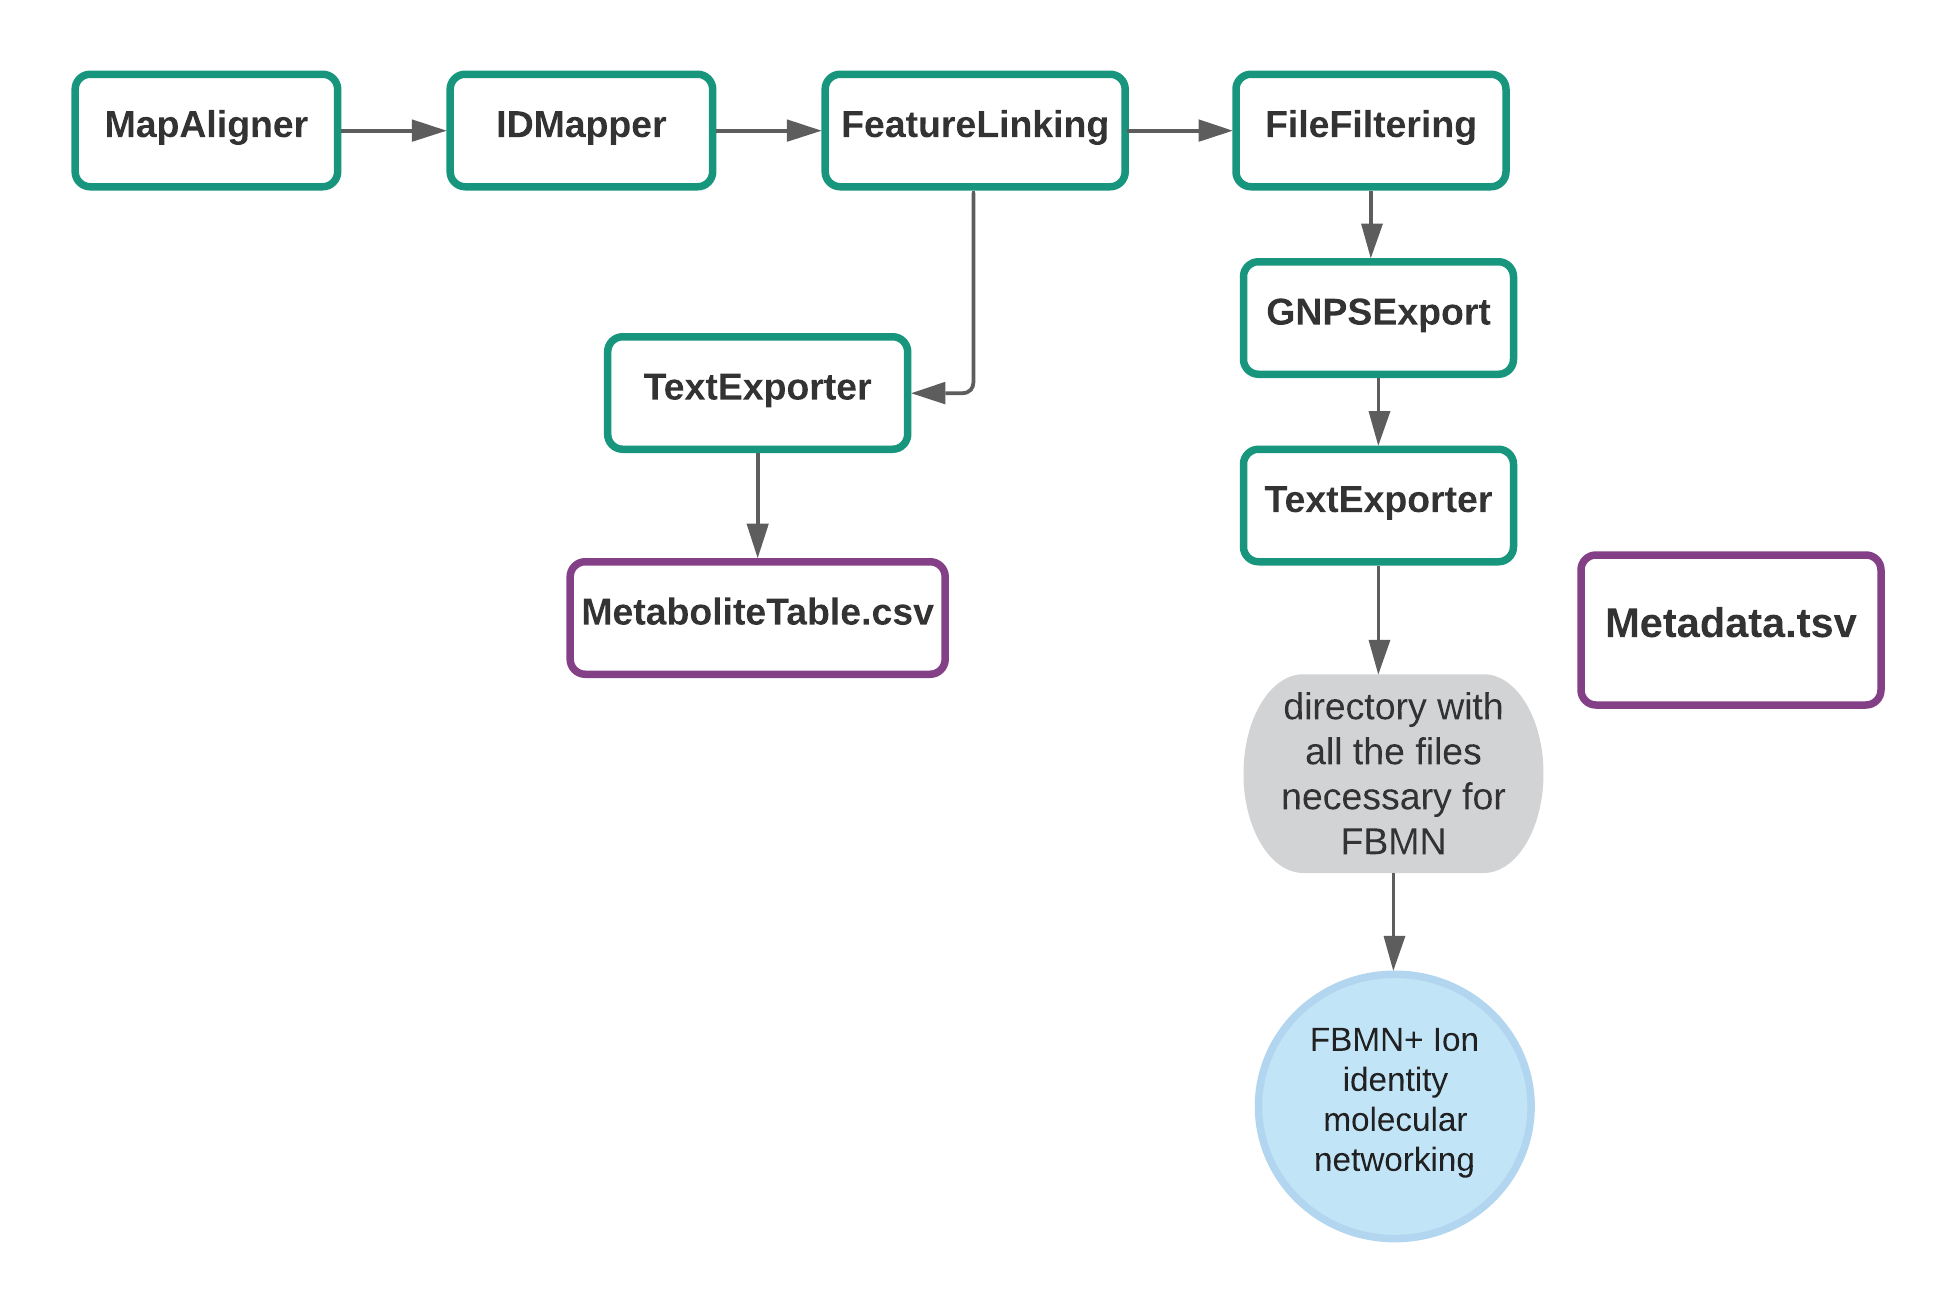

#### `1) Create a metadata tsv file for GNPS`

In [ ]:
path= os.path.join("results", "GNPSexport")
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

# Create a metadata table from the list of mzML files 

metadata = pd.DataFrame()
metadata["filename"] = [file for file in os.listdir(os.path.join("data", "mzML")) if file.endswith(".mzML")]
metadata["ATTRIBUTE_MAPID"]= ["MAP" + str(i) for i in range(len(metadata))]
metadata['ATTRIBUTE_genomeID']=metadata['filename'].str.extract(r'(NBC_?\d*)')
metadata['ATTRIBUTE_genomeIDMDNA']=metadata['filename'].str.extract(r'(MDNAWGS?\d*|MDNA_WGS_?\d*)')
metadata['ATTRIBUTE_genomeID']=metadata['ATTRIBUTE_genomeID'].fillna(metadata['ATTRIBUTE_genomeIDMDNA'])
metadata["ATTRIBUTE_media"]= metadata['filename'].str.extract(r'(ISP2|DNPM|FPY12|MA|soyM\d*)')
metadata["ATTRIBUTE_comment"]= metadata['ATTRIBUTE_genomeID'].astype(str) +"_" + metadata["ATTRIBUTE_media"].astype(str)
metadata=metadata.drop(columns="ATTRIBUTE_genomeIDMDNA")
metadata.to_csv(os.path.join(path, "metadata.tsv"), sep='\t')
metadata

Import aligned feature files and load them to a FeatureMap() file

#### `2) File Filter` 

Remove the features that do not have an MS2 pattern

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FileFilter.html

In [ ]:
path= os.path.join("results", "interim", "GNPSexport")
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_consensus= os.path.join("results", "interim", "Preprocessing", "consensus.consensusXML")
cmap = ConsensusMap()
ConsensusXMLFile().load(input_consensus, cmap)
new_map= ConsensusMap(cmap)
new_map.clear(False)
for f in cmap:
    if f.getPeptideIdentifications() !=[]:
        new_map.push_back(f)
        
Consensus_file= os.path.join(path ,'filtered' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, new_map)

#### `3) MSMS clustering`

The algorithm creates an MGF file with only the MS2 information of all files (introduce mzml files with spaces between them)

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/TOPP_GNPSExport.html

In [ ]:
consensus= os.path.join(path, "filtered.consensusXML")
input_mzml_files=sorted(glob.glob(os.path.join("results", "interim", "Preprocessing", "MapAligned_*.mzML")))
out_file= os.path.join("results", "GNPSexport", "MSMS.mgf")

In [ ]:
spectra_clustering= GNPSMGFFile()
spectra_clustering.store(consensus, [s.encode() for s in input_mzml_files], out_file)

#### `4) FeatureQuantificationTable.txt`

Convert the consensusXML file to a txt file for GNPS

In [ ]:
cmap = ConsensusMap()
ConsensusXMLFile().load(consensus, cmap)
out_quant= os.path.join("results", "GNPSexport", "FeatureQuantificationTable.txt")
GNPS_matrix= GNPSQuantificationFile()
GNPS_matrix.store(cmap, String(out_quant))

#### `5) IIMN (Ion Identity Molecular Networking)`:

https://ccms-ucsd.github.io/GNPSDocumentation/fbmn-iin/#iimn-networks-with-collapsed-ion-identity-edges

In [ ]:
df = cmap.get_df()
df.insert(0, "best ion", [f.getMetaValue("best ion") for f in cmap])
df["LinkedGroups"] = [set(s.decode() for s in f.getMetaValue("LinkedGroups")) for f in cmap]
df.insert(0, "FEATURE_ID", ["e_" + str(cf.getUniqueId()) for cf in cmap])
df["partners"] = ""
for i in df.index:
    for j in df.iloc[i:].index:
        if i == j:
            continue
        if df.loc[i, "LinkedGroups"].intersection(df.loc[j, "LinkedGroups"]):
            if df.loc[i, "partners"]:
                df.loc[i, "partners"] += ";"
            if df.loc[j, "partners"]:
                df.loc[j, "partners"] += ";"
            df.loc[i, "partners"] += df.loc[j, "FEATURE_ID"]
            df.loc[j, "partners"] += df.loc[i, "FEATURE_ID"]
df = df.drop(["sequence", "LinkedGroups"], axis=1)
df.to_csv(os.path.join("results","GNPSexport", "SuppPairs.tsv"), sep="\t", index=False)